# Building the distributed seismicity model

Notes:
* The catalogue used for the smoothing contains only earthquakes with magnitude larger than the 'cutoff_magnitude' parameter defined in the .ini file of the project

In [1]:
%matplotlib inline
import os
import h5py
import numpy
import scipy
import pickle
import matplotlib.pylab as plt
from decimal import *
getcontext().prec = 4

from copy import deepcopy

from openquake.mbt.oqt_project import OQtProject, OQtSource
from openquake.mbt.tools.area import create_catalogue
from openquake.mbt.tools.smooth import Smoothing
from openquake.mbt.tools.mfd import get_evenlyDiscretizedMFD_from_truncatedGRMFD

from openquake.hazardlib.source import PointSource, SimpleFaultSource
from openquake.mbt.tools.geo import get_idx_points_inside_polygon
from openquake.hazardlib.mfd.evenly_discretized import EvenlyDiscretizedMFD
from openquake.hazardlib.mfd.truncated_gr import TruncatedGRMFD
from openquake.hazardlib.geo.point import Point
from openquake.hazardlib.geo.geodetic import azimuth, point_at

from openquake.hmtk.seismicity.selector import CatalogueSelector

from openquake.hazardlib.scalerel.wc1994 import WC1994
from openquake.hazardlib.tom import PoissonTOM
from openquake.hazardlib.pmf import PMF
from openquake.hazardlib.geo.nodalplane import NodalPlane 


from openquake.mbt.notebooks.sources_distributed_s.utils import get_xy, get_polygon_from_simple_fault

In [2]:
project_pickle_filename = os.environ.get('OQMBT_PROJECT')
oqtkp = OQtProject.load_from_file(project_pickle_filename)
model_id = oqtkp.active_model_id
model = oqtkp.models[model_id]
print('Active model ID is:', model_id)

TypeError: stat: can't specify None for path argument

In [ ]:
src_id = getattr(oqtkp,'active_source_id')[0]
print('Area source ID:', src_id)
src = model.sources[src_id]

In [48]:
%%bash
rm tmp*

rm: tmp*: No such file or directory


## Set the nodal plane distribution 

In [49]:
# 
# set the nodal plane distribution
nodal_plane_dist_filename = os.path.join(oqtkp.directory, model.nodal_plane_dist_filename)
fhdf5 = h5py.File(nodal_plane_dist_filename,'a')
#
# add the dataset for the current area source, if missing
if (src_id in fhdf5.keys() and not ((fhdf5[src_id]['strike'][0] == 0) and 
                                    (fhdf5[src_id]['dip'][0] == 0) and
                                    (fhdf5[src_id]['rake'][0] == 0))):
    print('Using source-specific nodal plane distribution')
    data = fhdf5[src_id][:]
    tpll = []    
    for idx in range(0, len(data)):
        nplane = NodalPlane(data['strike'][idx],
                            data['dip'][idx],
                            data['rake'][idx])
        tmp = Decimal('{:.2f}'.format(data['wei'][idx]))
        tpll.append((Decimal(tmp), nplane))
else:
    print('Using default nodal plane distribution')
    tpll = []
    npd = model.default_nodal_plane_dist
    for idx in range(0, len(npd['strike'])):
        nplane = NodalPlane(npd['strike'][idx],
                            npd['dip'][idx],
                            npd['rake'][idx])
        # tmp = float(data['wei'][idx])
        tmp = Decimal('{:.2f}'.format(data['wei'][idx]))
        tpll.append((Decimal(tmp), nplane))
nodal_plane_distribution = PMF(tpll)    
fhdf5.close()

Using source-specific nodal plane distribution


## Set the hypocentral depth distribution

In [50]:
# 
# read hypocentral depth file
hypo_dist_filename = os.path.join(oqtkp.directory, model.hypo_dist_filename)
fhdf5 = h5py.File(hypo_dist_filename,'a')
#
# check if the file contains information relative this source
if (src_id in fhdf5.keys() and not ((fhdf5[src_id]['depth'][0] == 0) and 
                                    (fhdf5[src_id]['wei'][0] == 0))):
    print('Using source-specific hypocentral depth distribution')
    data = fhdf5[src_id][:]
    tpll = []
    for idx in range(0, len(data)):
        #tmp = float(data['wei'][idx])
        tmp = Decimal('{:.2f}'.format(data['wei'][idx]))
        tpll.append((Decimal(tmp), data['depth'][idx]))
else:
    print('Using default hypocentral depth distribution')
    tpll = []
    hdd = model.default_hypo_dist
    for idx in range(0, len(hdd['dep'])):
        # tmp = float(hdd['wei'][idx])
        tmp = Decimal('{:.2f}'.format(hdd['wei'][idx]))
        tpll.append((Decimal(tmp), hdd['dep'][idx]))
hypocenter_distribution = PMF(tpll)    

Using source-specific hypocentral depth distribution


## Parameters

In [51]:
area_discretization = model.area_discretization 
buff = 2.0
faults_lower_threshold_magnitude = model.faults_lower_threshold_magnitude

## Create the dilated polygon around the area source
NOTE: We don't necessarily need to use the polygon of the area source. In a future version the polygon must be defined in the configuration file or computed automatically.

In [52]:
new_polygon = src.polygon.dilate(100)
polygon_mesh = new_polygon.discretize(area_discretization)
print('Number of points: %d' % (len(polygon_mesh)))

Number of points: 3819


## Get the earthquakes within the dilated polygon

In [53]:
# First we get the earthquakes of the catalogue within the dilated polygon 
pickle_filename = os.path.join(oqtkp.directory, oqtkp.models[model_id].declustered_catalogue_pickle_filename)
fin = open(pickle_filename, 'rb') 
catalogue = pickle.load(fin)
fin.close()
print('The calogue contains %d earthquakes' % (len(catalogue.data['magnitude'])))

The calogue contains 4556 earthquakes


In [54]:
# Then we create the subcatalogue for the dilated polygon
cutoff_magnitude = float(model.catalogue_cutoff_magnitude)
fcatal = create_catalogue(model, catalogue, polygon=new_polygon)
selector = CatalogueSelector(catalogue, create_copy=False)
selector.within_magnitude_range(cutoff_magnitude, 10.)

In [55]:
# Compute scaling factor based on completeness - For the time being we don't consider this.
scalf = numpy.ones((len(fcatal.data['magnitude'])))

## Smoothing 

In [56]:
smooth_param = model.smoothing_param
smooth = Smoothing(fcatal, polygon_mesh, 10)

In [57]:
values = smooth.gaussian(50, 20)
values = smooth.multiple_smoothing(smooth_param)
print('Max of smoothing:', max(values))

179.992 -15.777 6.39
179.5236888181349 180.45823894032654
179.9072 -15.6792 5.49
179.4391206541887 180.37322160584287
179.5793 -15.7007 5.06
179.1111698248193 180.04536925006232
179.984 -16.713 6.78
179.5133887621035 180.4523984955956
179.5833 -15.9288 5.48
179.11462581287267 180.0498793713974
179.7564 -16.0029 5.2
179.28754721426927 180.22314692133193
179.456 -15.838 5.45
178.9875434092121 179.92237528756883
179.7409 -15.6901 5.08
179.2727948944973 180.20694575093572
179.8662 -15.7399 5.3
179.39797695174926 180.33235631169873
179.6295 -16.3021 5.0
179.15991668747483 180.0969326379305
182.044 -15.873 6.59
181.57545969726638 182.5104537943539
184.856 -19.07 6.44
184.37892602293155 185.33049235808724
184.45 -18.156 6.77
183.9755485264273 184.9220156238142
181.41 -17.399 6.1
180.9376082608908 181.8800739586113
180.639 -17.376 6.73
180.16666927351253 181.10901649720574
184.605 -18.826 5.86
184.1286408257789 185.07881682632362
180.892 -15.957 6.43
180.42325795261652 181.35864302917003
185.2

185.379 -18.331 5.71
184.90405798425684 185.85147853476676
181.667 -15.405 6.15
181.19956217250757 182.13242057119956
180.982 -15.9687 5.06
180.51322975872924 181.4486694786548
184.092 -19.2958 5.17
183.61425489398033 184.56712690683278
183.546 -14.9283 5.06
183.07964791184045 184.0104046166052
183.379 -17.4198 5.7
182.90655300512344 183.8491260010467
185.237 -15.751 5.26
184.768750606991 185.7031810099108
183.547 -19.001 6.37
183.07012925442598 184.02130025886785
185.13 -19.8653 5.28
184.6505206251808 185.60676787002873
183.843 -17.8397 5.06
183.36942138975684 184.31419237766198
182.406 -16.1943 5.6
181.93668162919337 182.87318387791117
182.921 -15.7852 5.28
182.4526693074932 183.3872572335909
183.685 -16.5584 5.28
183.21477888206005 184.15303180131494
184.188 -17.924 5.88
183.7141904799659 184.6594101039058
185.774 -17.4689 5.39
185.30142227127078 186.24424914279408
182.911 -18.0502 5.17
182.43684245925192 183.38273833370036
182.833 -16.5939 5.39
182.36268966085206 183.3011156512432


186.198 -16.896 5.08
185.72692170307795 186.66683771019194
183.913 -16.5865 5.17
183.44270827676334 184.38109815536313
182.083 -15.58 5.61
181.61515418281536 182.54880275285683
185.736 -15.6977 5.14
185.2678769219092 186.20206259750722
182.828 -17.009 5.57
182.3566304342472 183.29711172219558
183.192 -17.252 5.27
182.71999663009726 183.66170825050386
185.252 -15.365 5.08
184.784654715536 185.71733391268054
180.524 -15.702 6.09
180.05586674894835 180.990072133292
185.357 -16.736 5.2
184.88633037531844 185.825453389718
185.202 -18.235 5.14
184.72732775545552 185.67422393725403
184.444 -15.09 5.83
183.97728380682145 184.90874513364034
185.032 -14.888 5.14
184.5657379903499 185.49632040370884
183.299 -18.79 5.54
182.82274537653444 183.772718047305
182.99 -15.947 5.36
182.52128203177824 183.45662044056982
183.212 -14.603 5.31
182.74636746183282 183.67573226593672
182.682 -16.749 5.51
182.21129733412988 183.15048445591745
183.523 -17.61 5.73
183.05004424048906 183.9936053025602
183.093 -17.3

183.174 -17.338 5.58
182.70176987576943 183.64392175761188
183.887 -19.663 5.02
183.40814353849407 184.36317827509217
185.38 -15.768 5.52
184.9117102193427 185.84621887499705
185.077 -15.4994 5.2
184.60934272158437 185.54262611338174
185.656 -15.6641 5.1
185.18795630696494 186.1219881891308
182.922 -17.094 5.1
182.45040989132826 183.39131925215148
183.431 -19.1138 5.2
182.9537965660145 183.90561473733067
184.615 -15.5456 5.2
184.1472347827916 185.0807272341822
184.544 -15.3047 5.1
184.07679372467032 185.00920376434624
183.04 -17.333 5.59
182.56778309425698 183.5099093101048
185.324 -14.9268 5.3
184.85765126939614 185.78840147746615
184.895 -15.529 5.62
184.42727360673183 185.36069086082873
180.791 -15.803 6.26
180.32262691651366 181.25729698116965
184.572 -18.7179 5.0
184.0959540656501 185.04552090056444
185.224 -17.5293 5.02
184.7512608743775 185.69440118718921
182.932 -17.0125 5.2
182.46062137761584 183.40112024354585
183.481 -19.0653 5.1
183.0039398936942 183.95547924628812
183.627 

183.61124869282457 183.9864027584315
183.877 -18.0255 5.24
183.68765811381326 184.06595544031316
184.133 -15.455 6.03
183.946225116107 184.31945095036323
183.446 -17.7193 5.37
183.256987625933 183.63463358800436
182.204 -15.276 5.96
182.01738736409203 182.39029291375695
182.963 -16.713 5.66
182.77502485969345 183.15062110764356
185.081 -16.3842 5.06
184.89334879529588 185.26830512640956
185.657 -15.0399 5.17
185.47059815819387 185.8430876484833
183.405 -14.8775 5.45
183.2187410411812 183.590948551606
184.464 -18.948 6.64
184.273625399469 184.65396469555276
184.947 -15.0051 5.45
184.76062892049302 185.13305769864144
184.069 -17.698 5.17
183.8800103042576 184.25761144023863
184.614 -14.9371 5.45
184.42768880312775 184.7999994017566
182.68 -16.714 6.53
182.49202386333423 182.86762207971304
184.996 -15.9744 5.28
184.80874235770378 185.18292139007443
183.223 -16.3728 5.6
183.0353598958455 183.41029430051216
185.694 -15.038 5.57
185.50759983978145 185.88008601127018
185.666 -15.68 5.41
185.4

182.61 -16.446 5.4
182.42228846640228 182.79736396508147
184.046 -15.515 5.73
183.85917025990474 184.2325043910809
184.839 -15.1281 5.3
184.65251983794371 185.02516390674924
185.755 -15.239 5.1
185.56842063921675 185.9412605070121
183.566 -18.2004 5.14
183.37646694993114 183.75514220113232
185.371 -15.8917 5.3
185.1838204207347 185.5578452984423
184.272 -14.7009 5.3
184.08589447364145 184.45779922096276
184.539 -15.397 6.12
184.35227791857545 184.72539951435311
184.154 -14.9384 5.02
183.9676876611338 184.34000051345717
185.592 -15.8036 5.2
185.40490308081172 185.7787647342865
180.374 -15.5187 5.3
180.18716686934323 180.56050769429058
185.023 -15.6012 5.5
184.8360910345051 185.20958157948746
183.194 -17.6117 5.0
183.00510186600872 183.38252202512632
185.037 -15.8943 5.0
184.84981797344363 185.22384768381306
185.536 -15.3923 5.7
185.3492821877089 185.72239535587087
184.969 -15.9108 5.0
184.7818024320799 185.15586283213244
185.346 -15.2928 5.1
185.1593722257741 185.5323076575439
182.624 -

(-22.3535, -13.450821)

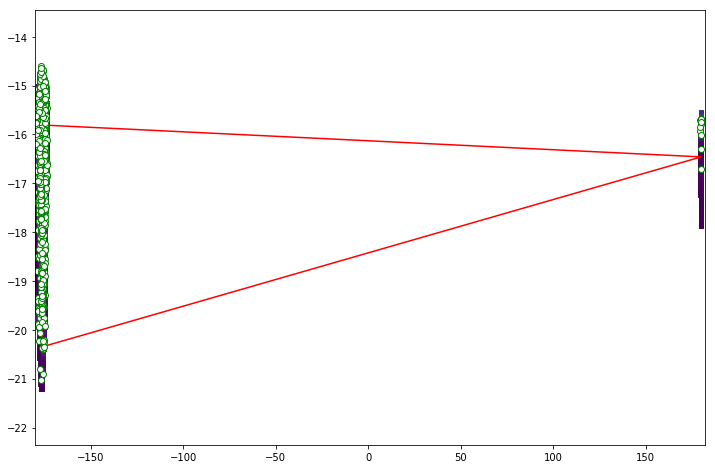

In [58]:
fig = plt.figure(figsize=(12,8))
ax = plt.subplot((111))
#
# plotting
plt.scatter(smooth.mesh.lons, smooth.mesh.lats, c=values, vmin=0, vmax=max(values), marker='s', s=15)
plt.plot(src.polygon.lons, src.polygon.lats, 'r')
plt.plot(fcatal.data['longitude'], fcatal.data['latitude'], 'og', mfc='white')
#
# find min and max longitude and latitude of the area source polygon
lomin = min(src.polygon.lons) - buff
lamin = min(src.polygon.lats) - buff
lomax = max(src.polygon.lons) + buff
lamax = max(src.polygon.lats) + buff
#
# fix axes limits
ax.set_xlim([lomin, lomax])
ax.set_ylim([lamin, lamax])

In [59]:
%%bash
rm tmp*

## Select the nodes of the grid within the area source

In [67]:
src.polygon.lons = ([x+360 if x<0 else x for x in src.polygon.lons])
idxp = smooth.get_points_in_polygon(src.polygon)

### Plotting

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = plt.subplot((111))
plt.scatter(smooth.mesh.lons[idxp], smooth.mesh.lats[idxp], vmin=0, vmax=0.4, c=values[idxp], marker='s', s=15)
plt.plot(src.polygon.lons, src.polygon.lats, 'r')
if 'ids_faults_inside' in src.__dict__:
    for iii, key in enumerate(sorted(src.ids_faults_inside.keys())): 
        tsrc = model.sources[key] 
        coord = numpy.array(get_polygon_from_simple_fault(tsrc))
        plt.plot(coord[:,0], coord[:,1], 'r')
#
# fix axes limits
ax.set_xlim([lomin, lomax])
ax.set_ylim([lamin, lamax])

## Assigning seismicity to the source
The redistribution of seismicity to the source is done for each cell using as a scaling factor the ratio of the value assigned to the node and the sum of the values of all the nodes within the area source. Note that the mfd assigned to the area source must be an EvenlyDiscretisedMFD instance.

In [ ]:
scaling_factor = 1. /sum(values[idxp])
if isinstance(src.mfd, TruncatedGRMFD):
    newmfd = get_evenlyDiscretizedMFD_from_truncatedGRMFD(src.mfd)
    src.mfd = newmfd
mfdpnts = numpy.array([src.mfd.occurrence_rates]*len(values))*scaling_factor
#
#
xxx = numpy.tile(values, (mfdpnts.shape[1], 1)).T
mfdpnts = mfdpnts * numpy.tile(values, (mfdpnts.shape[1], 1)).T
#
# 
mags = []
for mag, _ in src.mfd.get_annual_occurrence_rates():
    mags.append(mag)   

## Cutting the MFDs of the point sources close to faults

In [ ]:
#
# find index of magnitudes above the threshold
jjj = numpy.nonzero(numpy.array(mags) > faults_lower_threshold_magnitude)
chng = numpy.zeros_like((values))
#
# create figure
fig = plt.figure(figsize=(12, 10))
ax = plt.subplot(111)
#
#
if hasattr(src, 'ids_faults_inside'):
    for iii, key in enumerate(sorted(src.ids_faults_inside.keys())): 
        #
        # Getting the fault source
        tsrc = model.sources[key]
        print('Source:', key)
        
        if 'mfd' in tsrc.__dict__ and tsrc.mfd is not None:
        
            lons, lats = get_xy(tsrc.trace) 

            # Create the polygon representing the surface projection of the fault
            # surface
            coord = numpy.array(get_polygon_from_simple_fault(tsrc))
            #
            #
            min_lon = numpy.min(lons)-buff
            max_lon = numpy.max(lons)+buff
            min_lat = numpy.min(lats)-buff
            max_lat = numpy.max(lats)+buff

            idxs = list(smooth.rtree.intersection((min_lon, min_lat, max_lon, max_lat)))

            iii = get_idx_points_inside_polygon(smooth.mesh.lons[idxs], 
                                                smooth.mesh.lats[idxs],
                                                list(coord[:,0]), 
                                                list(coord[:,1]), 
                                                idxs,
                                                15000.0) 
            
            for tidx in iii:
                plt.plot(smooth.mesh.lons[tidx], smooth.mesh.lats[tidx], 'o')
                mfdpnts[tidx, jjj] = 0.
                chng[tidx] = 1.

plt.plot(src.polygon.lons, src.polygon.lats, 'g', lw=4)
for iii, key in enumerate(sorted(src.ids_faults_inside.keys())): 
        tsrc = model.sources[key]
        lons, lats = get_xy(tsrc.trace) 
        coord = numpy.array(get_polygon_from_simple_fault(tsrc))
        plt.plot(coord[:,0], coord[:,1], 'r')

# fix axes limits
ax.set_xlim([lomin, lomax])
ax.set_ylim([lamin, lamax])

## Map

# Create the nrml sources 

In [ ]:
nrmls = [] 

import importlib
module = importlib.import_module('openquake.hazardlib.scalerel')
my_class = getattr(module, model.msr)
magnitude_scaling_relationship = my_class()

rupture_mesh_spacing = model.fault_rupture_mesh_spacing
rupture_aspect_ratio = model.fault_rupt_aspect_ratio
temporal_occurrence_model = PoissonTOM(1.)

for eee, iii in enumerate(idxp):
    jjj = numpy.nonzero(mfdpnts[iii, :] > 0)
    
    if len(list(mfdpnts[iii, jjj][0])) > 0:
        tmfd = EvenlyDiscretizedMFD(src.mfd.min_mag, src.mfd.bin_width, list(mfdpnts[iii, jjj][0]))

        points = PointSource(
            source_id='ds_%s_%d' % (src_id,eee),
            name='', 
            tectonic_region_type=src.tectonic_region_type,
            mfd=tmfd, 
            rupture_mesh_spacing=rupture_mesh_spacing,
            magnitude_scaling_relationship=magnitude_scaling_relationship, 
            rupture_aspect_ratio=rupture_aspect_ratio,
            temporal_occurrence_model=temporal_occurrence_model,
            upper_seismogenic_depth=model.upper_seismogenic_depth, 
            lower_seismogenic_depth=src.lower_seismogenic_depth,
            location=Point(smooth.mesh.lons[iii], smooth.mesh.lats[iii]), 
            nodal_plane_distribution=nodal_plane_distribution, 
            hypocenter_distribution=hypocenter_distribution
            )
        nrmls.append(points)

In [ ]:
import re
from openquake.hazardlib.sourcewriter import write_source_model
# Write the nrml file
model_dir = os.path.join(oqtkp.directory, 'nrml/%s' % (re.sub('\s','_',model_id)))
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_name = 'gridded_seismicity_source_%s.xml' % (src_id)
out_model_name = os.path.join(model_dir, model_name)
_ = write_source_model(out_model_name, nrmls, 'Model %s')
print('Created %s ' % (out_model_name))